In [40]:
%matplotlib notebook

In [41]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

In [42]:
line = xt.Line.from_json('pimms_00_optics.json')
line.configure_bend_model(core='bend-kick-bend', edge='full')

Loading line from dict:   0%|          | 0/220 [00:00<?, ?it/s]

Done loading line from dict.           


In [43]:
line.insert_element(
            'septum',
            xt.LimitRect(min_x=-0.1, max_x=0.1, min_y=-0.1, max_y=0.1),
            index='es_septum')

In [44]:
optq = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['kqf1', 'kqf2'], limits=(0, 1),  step=1e-3, tag='qf'),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3, tag='qd'),
        xt.VaryList(['ksf', 'ksd'], step=1e-3),
        
    ],
    targets=[
        xt.TargetSet(qx=1.663, qy=1.72, tol=1e-6),
        xt.TargetSet(dqx=-0.1, dqy=-0.1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='es_septum', tol=1e-6)
    ]
)
optq.step(20)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [45]:
tw = line.twiss(method='4d')

In [46]:
line.vars['kse1'] = 1
line.vars['kse2'] = -6.5

In [47]:
def characterize_phase_space_at_septum(line, num_turns=2000, plot=False):
    x = np.linspace(0, 2.5e-2, 20)
                                       
    # Localize transition between stable and unstable
    x_septum = 3.5e-2

    x_stable = 0
    x_unstable = 3e-2
    while x_unstable - x_stable > 1e-6:
        x_test = (x_stable + x_unstable) / 2
        p = line.build_particles(x=x_test, px=0)
        line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
        mon_test = line.record_last_track
        if (mon_test.x > x_septum).any():
            x_unstable = x_test
        else:
            x_stable = x_test 
    
    p = line.build_particles(x=[x_stable, x_unstable], px=0)
    line.track(p, num_turns=num_turns, turn_by_turn_monitor=True)
    mon_separatrix = line.record_last_track
    nc_sep = tw.get_normalized_coordinates(mon_separatrix)                                
    
    z_triang = nc_sep.x_norm[0, :] + 1j * nc_sep.px_norm[0, :]
    r_triang = np.abs(z_triang)
    
    # Find fixed points
    i_fp1 = np.argmax(r_triang)
    z_fp1 = z_triang[i_fp1]
    r_fp1 = np.abs(z_fp1)

    mask_fp2 = np.abs(z_triang - z_fp1 * np.exp(1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
    i_fp2 = np.argmax(r_triang * mask_fp2)

    mask_fp3 = np.abs(z_triang - z_fp1 * np.exp(-1j * 2 / 3 * np.pi)) < 0.2 * r_fp1
    i_fp3 = np.argmax(r_triang * mask_fp3)

    x_norm_fp = np.array([nc_sep.x_norm[0, i_fp1],
                          nc_sep.x_norm[0, i_fp2],
                          nc_sep.x_norm[0, i_fp3]])
    px_norm_fp = np.array([nc_sep.px_norm[0, i_fp1],
                           nc_sep.px_norm[0, i_fp2],
                           nc_sep.px_norm[0, i_fp3]])
    
    stable_area = np.linalg.det([x_norm_fp, px_norm_fp, [1, 1, 1]])

    # Measure slope of the separatrix at the semptum
    x_separ = mon_separatrix.x[1, :]
    px_separ = mon_separatrix.px[1, :]
    x_norm_separ = nc_sep.x_norm[1, :]
    px_norm_separ = nc_sep.px_norm[1, :]
    
    x_separ[px_norm_separ < -1e-2] = 99999999. # TEEEEEST
        
    i_septum = np.argmin(np.abs(x_separ - x_septum))

    poly_sep = np.polyfit([x_separ[i_septum + 3], x_separ[i_septum - 3]],
                             [px_separ[i_septum + 3], px_separ[i_septum - 3]],
                              deg=1)
    slope_separatrix = poly_sep[0]

    if plot:
        particles = line.build_particles(x=x, px=0)
        line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
        mon = line.record_last_track
        nc = tw.get_normalized_coordinates(mon) 

        plt.figure(figsize=(10, 5))
        ax_geom = plt.subplot(1, 2, 1)
        plt.plot(mon.x.T, mon.px.T, '.', markersize=1, color='C0')
        plt.ylabel(r'$p_x$')
        plt.xlabel(r'$x$ [m]')
        plt.xlim(-5e-2, 5e-2)
        plt.ylim(-5e-3, 5e-3)
        ax_norm = plt.subplot(1, 2, 2)
        plt.plot(nc.x_norm.T * 1e3, nc.px_norm.T * 1e3,
                 '.', markersize=1, color='C0')
        plt.xlim(-15, 15)
        plt.ylim(-15, 15)
        plt.gca().set_aspect('equal', adjustable='datalim')

        plt.xlabel(r'$\hat{x}$ [$10^{-3}$]')
        plt.ylabel(r'$\hat{y}$ [$10^{-3}$]')

        # Plot separatrix
        ax_geom.plot(mon_separatrix.x[0, :], mon_separatrix.px[0, :], '.', color='C2')
        ax_geom.plot(mon_separatrix.x[1, :], mon_separatrix.px[1, :], '.', color='C1')
        ax_norm.plot(nc_sep.x_norm[0, :] * 1e3, nc_sep.px_norm[0, :] * 1e3, '.', color='C2')
        ax_norm.plot(nc_sep.x_norm[1, :] * 1e3, nc_sep.px_norm[1, :] * 1e3, '.', color='C1')
        ax_norm.plot(x_norm_fp*1e3, px_norm_fp*1e3, '*', markersize=10, color='k')

        x_plt = [x_septum - 1e-2, x_septum + 1e-2]
        ax_geom.plot(x_plt, np.polyval(poly_sep, x_plt), '--k', linewidth=3)
                                       
    return {
        'slope_at_septum': slope_separatrix,
        'stable_area': stable_area,
        'x_norm_fp': x_norm_fp,
        'px_norm_fp': x_norm_fp,
    }

In [48]:
%time characterize_phase_space_at_septum(line, num_turns=1000)

CPU times: user 192 ms, sys: 722 ms, total: 914 ms
Wall time: 114 ms


{'slope_at_septum': -0.05453565346029323,
 'stable_area': 8.010290658550247e-05,
 'x_norm_fp': array([-0.00334893, -0.0024541 ,  0.00545492]),
 'px_norm_fp': array([-0.00334893, -0.0024541 ,  0.00545492])}

<IPython.core.display.Javascript object>


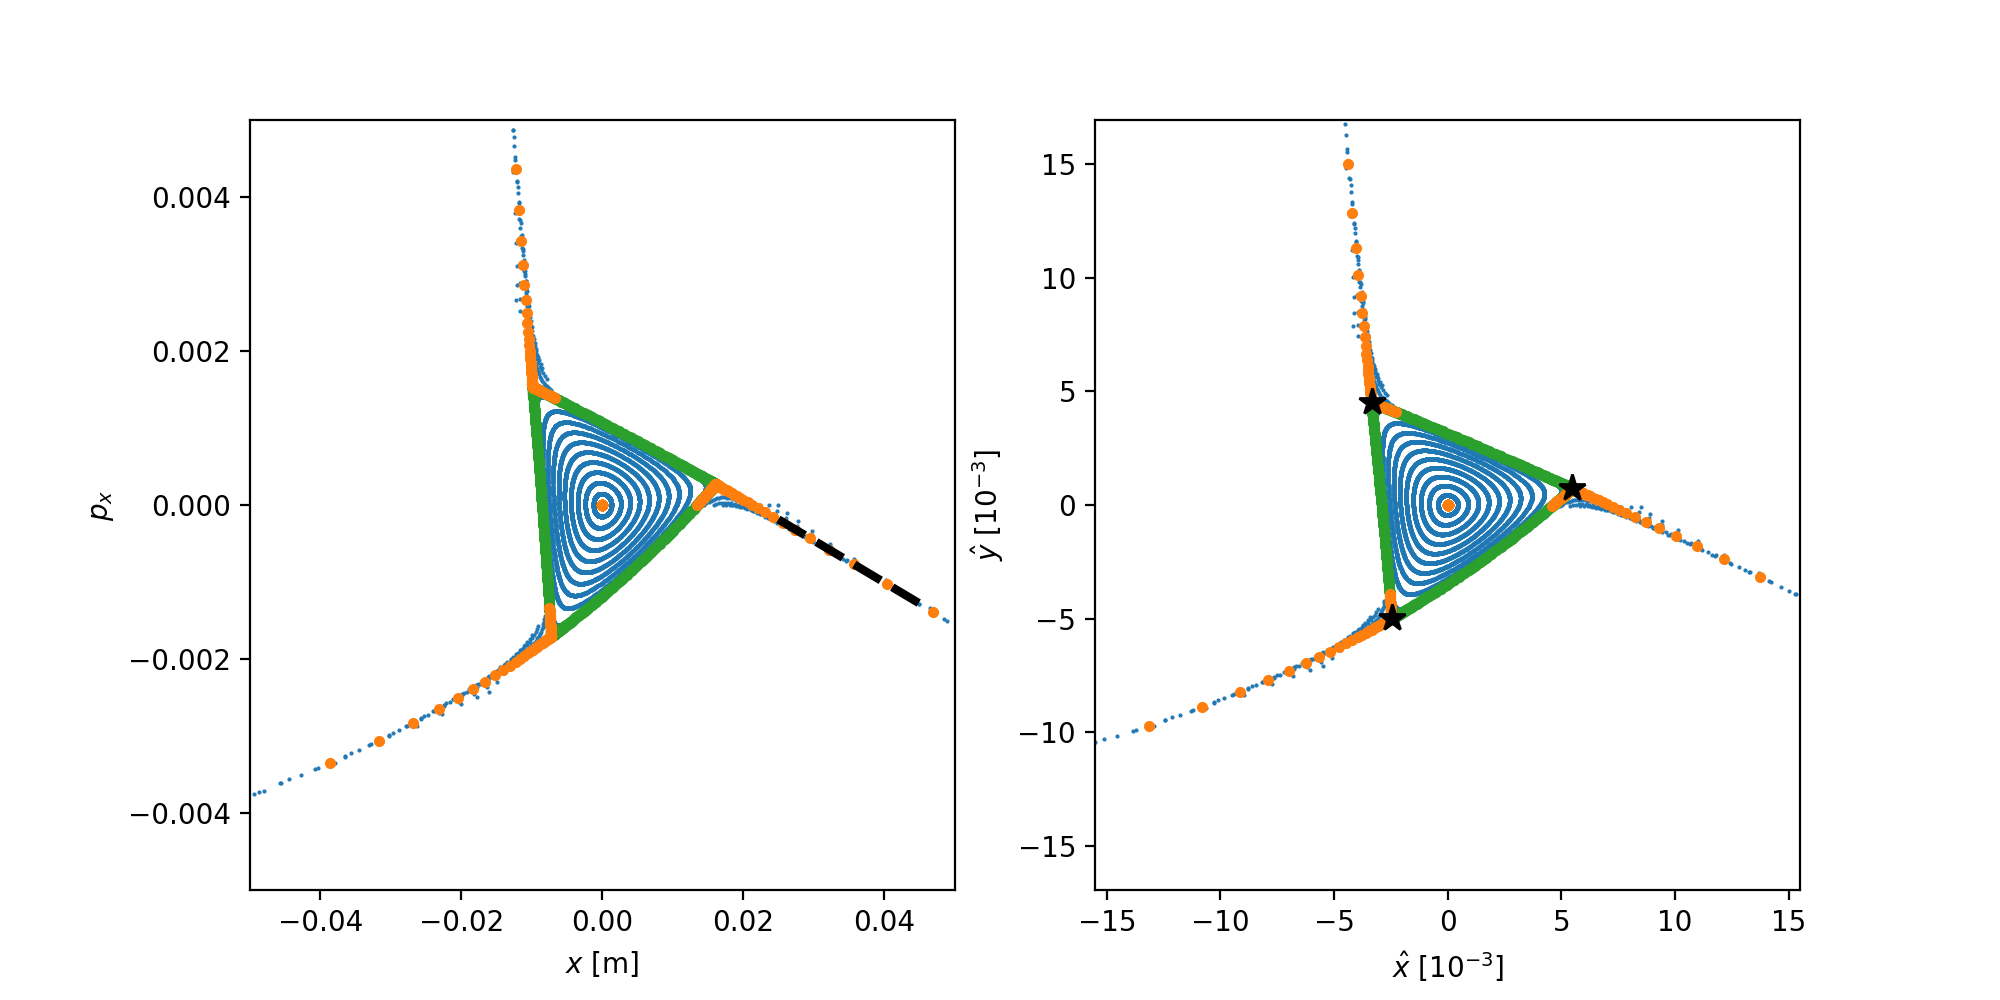

{'slope_at_septum': -0.05453565346029323,
 'stable_area': 8.010290658550247e-05,
 'x_norm_fp': array([-0.00334893, -0.0024541 ,  0.00545492]),
 'px_norm_fp': array([-0.00334893, -0.0024541 ,  0.00545492])}

In [49]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)

In [50]:
class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line)
        return out

In [51]:
action = ActionSeparatrix(line)

In [52]:
action.run()

{'slope_at_septum': -0.05453565346029323,
 'stable_area': 8.010293498777225e-05,
 'x_norm_fp': array([-0.00334863, -0.00245428,  0.00545492]),
 'px_norm_fp': array([-0.00334863, -0.00245428,  0.00545492])}

In [53]:
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, tag='resonance',
                     limits=[-7, 7]),
    targets=[
        action.target('stable_area', 1.e-4, tol=1e-5, weight=100), 
        action.target('slope_at_septum', 0.03, tol=5e-4)
    ]
)

In [54]:
opt.target_status()

Target status:                          
id state tag tol_met      residue current_val target_val description                                 
 0 ON          False -1.98971e-05 8.01029e-05     0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
 1 ON          False   -0.0845357  -0.0545357       0.03 'slope_at_septum', val=0.03, tol=0.0005, ...


In [55]:
def err_fun(x):
    out = opt._err(x, check_limits=False)
    #print(f'x = {repr(x)}, out = {out}')
    return out

bounds = np.array([vv.limits for vv in opt._err.vary])
opt._err.return_scalar = True
import pybobyqa
soln = pybobyqa.solve(err_fun, x0=opt.log().vary[0, :], bounds=bounds.T,
            rhobeg=5, rhoend=1e-4, maxfun=80, objfun_has_noise=True,
            seek_global_minimum=True)
err_fun(soln.x) # set it to the best solution
opt.tag('pybobyqa')
opt.target_status()

Target status:               nalty = 2.054e-11              
id state tag tol_met      residue current_val target_val description                                 
 0 ON           True  1.27659e-08 0.000100013     0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
 1 ON           True -4.34865e-06   0.0299957       0.03 'slope_at_septum', val=0.03, tol=0.0005, ...


In [56]:
opt.vary_status()

Vary status:                 
id state tag       name lower_limit current_val upper_limit val_at_iter_0 step weight
 0 ON    resonance kse1          -7     4.35288           7             1  0.5      1
 1 ON    resonance kse2          -7    0.902516           7          -6.5  0.5      1


<IPython.core.display.Javascript object>


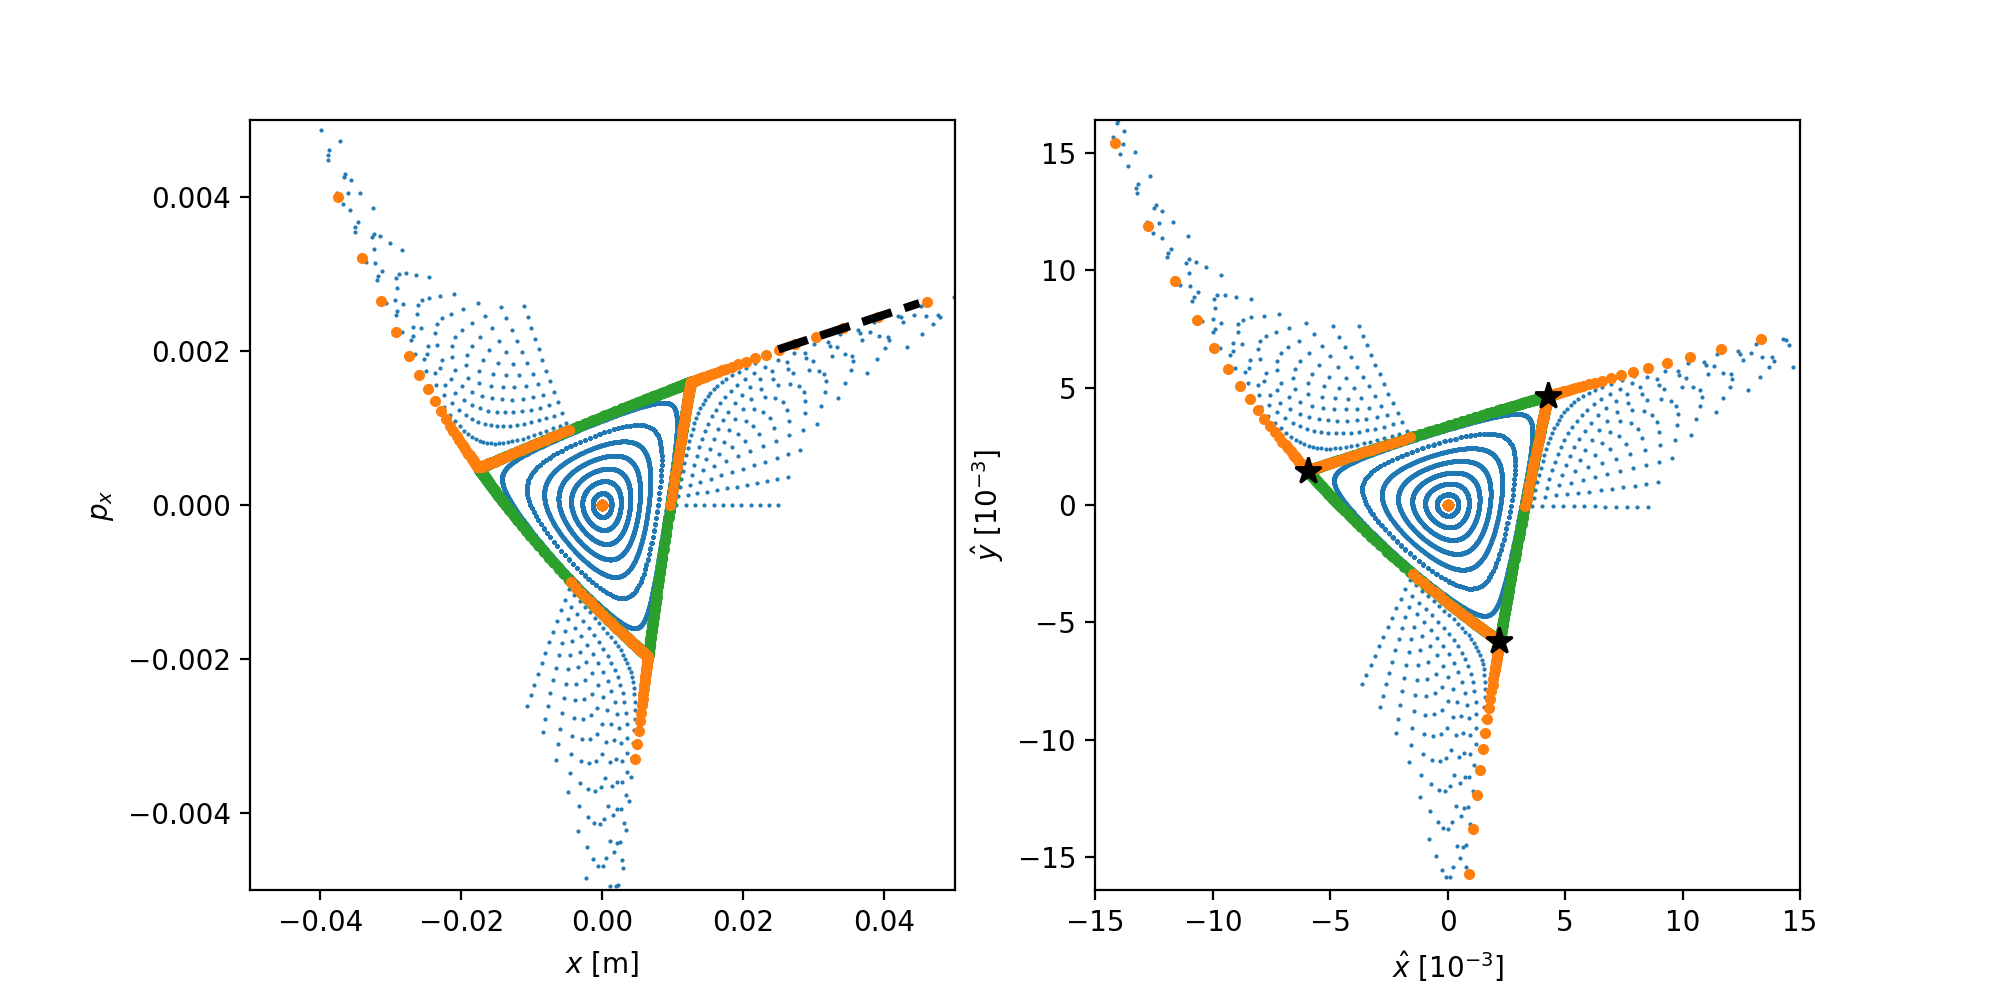

{'slope_at_septum': 0.029995651353596244,
 'stable_area': 0.00010001282969062837,
 'x_norm_fp': array([ 0.0042539 , -0.00596248,  0.00220439]),
 'px_norm_fp': array([ 0.0042539 , -0.00596248,  0.00220439])}

In [57]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)